# Golf Handicap Tracker

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

%matplotlib inline
pd.set_option("display.max_rows", None)

import warnings

warnings.filterwarnings("ignore")

In [22]:
from utils import add_round, get_handicap, fill_handicaps, plot_statistics, histplot, pie_chart, dist_plot, rolling_avg, scatter

In [23]:
df = pd.DataFrame(columns=["name", "date", "adj_gross_score", "course_rating", "handicap_diff", "slope_rating", \
                           "putts", "3_putts", "fairways_hit", "gir", "penalty/ob"])

In [24]:
df.head()

,name,date,adj_gross_score,course_rating,handicap_diff,slope_rating,putts,3_putts,fairways_hit,gir,penalty/ob


In [353]:
def add_round(name:str, date:str, adj_gross_score:int, course_rating:np.number, slope_rating:np.number, \
              putts:int, three_putts:int, fairways:int, gir:int, penalties:int, df:pd.DataFrame=df) -> pd.Series:
    
    """ Given specified input data, a new row will be added to the dataframe

    Args:
    ------------------
    name:str | name of player who's score is being recorded
    date:str | day of the round being recorded
    adj_gross_score:int | total score for the round
    course_rating:np.number | course rating found on the scorecard
    slope_rating:np.number | slope rating found on the scorecard
    putts:int | optional if recorded, the total number of putts
    three_putts:int | optional if recorded, the total number of 3-putts
    fairways:int | options if recorded, the total number of fairways hit on par 4's and par 5's
    gir:int | optional greens in regulation, the total number of gir on all 18 holes
    penalties:int | optional total number of instances of out-of-bounds shots or water penalties
    df:pd.DataFrame | original container of data


    """
    row = {
        "name":name,
        "date":pd.to_datetime(date).normalize(),
        "adj_gross_score":adj_gross_score,
        "course_rating":course_rating,
        "slope_rating":slope_rating,
        "putts": putts,
        "3_putts": three_putts, 
        "fairways_hit": fairways,
        "gir": gir, 
        "penalty/ob": penalties
    }

    row["handicap_diff"] = ((row["adj_gross_score"] - row["course_rating"]) * 113) / row["slope_rating"]
    
    df.loc[len(df)] = row
    
    return df

In [25]:
# Testing Function

add_round(name="Dave", date="2024-07-22", adj_gross_score=80, course_rating=72, slope_rating=113, putts=36, \
          three_putts=0, fairways=6, gir=12, penalties=1, data=df)
df.shape

(1, 11)

In [26]:
df

,name,date,adj_gross_score,course_rating,handicap_diff,slope_rating,putts,3_putts,fairways_hit,gir,penalty/ob
0,Dave,2024-07-22,80,72,8.0,113,36,0,6,12,1


In [27]:
# Loop to create fake data

today = pd.Timestamp.today()

for n in ["Pete", "Dave", "Eric"]:
    # Populate the fields for the add_round() call
    avg_score = np.random.randint(low=80, high=90)
    avg_putts = np.random.randint(low=18, high=54)
    avg_three_putts = np.random.randint(low=0, high=10)
    avg_fairways = np.random.randint(low=1, high=14)
    avg_gir = np.random.randint(low=0, high=18)
    avg_penalities = np.random.randint(low=0, high=10)
    for i in range(100):
        name = n
        date = today + pd.Timedelta(days=i * np.random.choice([2,3]))
        adj_gross_score = int(max(np.random.normal(loc=avg_score, scale=5, size=1), 72))
        course_rating = float(np.random.choice([71, 71.5, 72, 72.5, 73, 73.5]))
        slope_rating = int(np.random.randint(low=110, high=130, size=1))
        putts = int(max(np.random.normal(loc=avg_putts, scale=5, size=1), 0))
        three_putts = int(max(np.random.normal(loc=avg_three_putts, scale = 1, size = 1), 0))
        fairways = int(max(np.random.normal(loc=avg_fairways, scale = 2, size = 1),0))
        gir = int(max(np.random.normal(loc=avg_gir, scale = 2, size = 1),0))
        penalties = int(max(np.random.normal(loc=avg_penalities, scale = 2, size = 1),0))
    
        # Call function and add to the df
        add_round(name=name, date=date, adj_gross_score=adj_gross_score, course_rating=course_rating, 
                  slope_rating=slope_rating, putts=putts, three_putts=three_putts, fairways=fairways, gir=gir, penalties=penalties, data=df)

In [28]:
print(df.shape)
df.head()

(301, 11)


,name,date,adj_gross_score,course_rating,handicap_diff,slope_rating,putts,3_putts,fairways_hit,gir,penalty/ob
0,Dave,2024-07-22,80,72.0,8.000000,113,36,0,6,12,1
1,Pete,2024-07-23,88,72.0,14.942149,121,21,1,7,12,3
2,Pete,2024-07-25,91,71.5,17.081395,129,26,1,5,11,1
3,Pete,2024-07-27,87,73.0,14.252252,111,25,1,5,12,0
4,Pete,2024-08-01,96,72.0,22.983051,118,27,1,3,10,2


<Axes: >

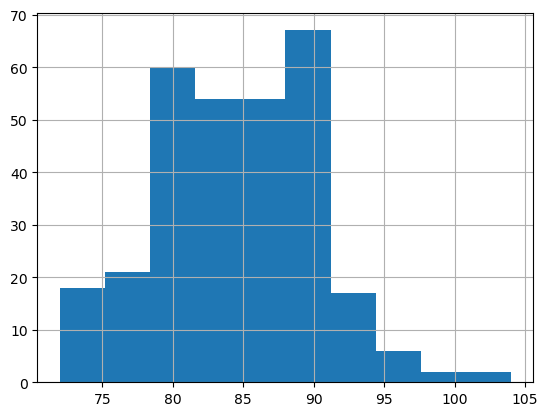

In [29]:
df["adj_gross_score"].hist()

In [360]:
def get_handicap(data, window=5):

    """
    Return a pd.Series of handicap values based on the window of rounds desired

    Args:
    --------------
    data: pd.DataFrame | dataframe containing all round data filtered by player name
    window: int | number of rounds for which your handicap should be based on

    Returns:
    ---------------
    rolling_means: pd.Series | a Series of values containing the calculated handicap scores
    """

    if window == 5:
        scores = 3
    elif window == 10:
        scores = 5
    else:
        scores = 8
    
    data = data.sort_values(by="date", ascending=True)
    if len(df) < window:
        return pd.Series([None] * len(series), index=data.index)
    rolling_means = data["handicap_diff"].rolling(window).apply(lambda x: x.nsmallest(scores).mean(), raw=False)
    return rolling_means

In [361]:
def fill_handicaps(data:pd.DataFrame) -> pd.DataFrame:
    """ Apply the get_handicap() function for each player in the data for 5, 10, and 20 round windows

    Args:
    -----------------
    df: pd.DataFrame | the source of data to be tracked

    Returns:
    -----------------
    df: pd.DataFrame | the supplied dataframe with added columns for each window of handicap
    """
    data = data.sort_values(by="date")
    
    for name in data["name"].unique():
        values = get_handicap(data.loc[data["name"] == name], window=5)
        data.loc[data["name"] == name, "fiveRd_handicap"] = values
    
        data.loc[data["name"] == name, "tenRd_handicap"] = get_handicap(df.loc[df["name"] == name], window=10)
    
        data.loc[data["name"] == name, "twentyRd_handicap"] = get_handicap(df.loc[df["name"] == name], window=20)

    return data

In [30]:
# Filling the handicaps
df = fill_handicaps(df)

NameError: name 'df' is not defined

In [363]:
df.head()

,name,date,adj_gross_score,course_rating,handicap_diff,slope_rating,putts,3_putts,fairways_hit,gir,penalty/ob,fiveRd_handicap,tenRd_handicap,twentyRd_handicap
0,Dave,2024-07-22,80,72.0,8.000000,113.0,36,0,6,12,1,NaN,NaN,NaN
1,Dave,2024-07-23,90,71.0,19.169643,112.0,48,0,8,15,7,NaN,NaN,NaN
2,Eric,2024-07-24,88,72.0,16.436364,110.0,41,7,7,9,1,NaN,NaN,NaN
3,Dave,2024-07-25,86,73.0,11.476562,128.0,44,5,0,7,0,NaN,NaN,NaN
4,Pete,2024-07-26,86,72.0,12.861789,123.0,43,8,12,1,0,NaN,NaN,NaN


In [364]:
def plot_statistics(data:pd.DataFrame, column:str, color_map:dict = {"Dave":'#636EFA', "Pete":'#EF553B', "Eric":'#00CC96'}):

    # '#636EFA', '#EF553B', '#00CC96'
    """ Creates a line plot of data tracking the values of a given column over time

    Args:
    ------------------
    data:pd.DataFrame | source of data for the values in the plot
    column:str | name of the column from data to plot

    Returns:
    ------------------
    fig: px.Figure | plotly figure of a lineplot
    """

    label_dict = {
        "adj_gross_score":"Adjusted Gross Score", 
        "handicap_diff": "Handicap Differential",
        "putts": "Putts per Round",
        "3_putts": "3-Putts per Round",
        "fairways_hit": "Fairways Hit per Round",
        "gir": "Greens in Regulation",
        "penalty/ob": "Penalties / OB per Round",
        "fiveRd_handicap": "Five-Round Rolling Handicap",
        "tenRd_handicap": "Ten-Round Rolling Handicap",
        "twentyRd_handicap": "Twenty-Round Rolling Handicap"
    }

        
    if len(data.dropna(subset=column)["date"].unique()) < 50:
        length = len(data.dropna(subset=column)["date"].unique()) 
    else:
        length = 50

    date_cutoff = pd.Series(data.dropna(subset=column)["date"].unique()).sort_values().to_list()[-length]
    
    period = f"- Last {length} Days"
    
    fig = px.line(data_frame=data.dropna(subset=column).loc[data["date"] >= date_cutoff],\
                  x="date", y=column, color="name", markers=True, hover_name="name",\
                 title=f"{label_dict[column]} per Round of Golf {period}", labels={"date":"Date", column:label_dict[column]},
                 hover_data={"name":False}, color_discrete_map=color_map)
    
    fig.update_layout(legend={"title":"Player Name"})

    return fig

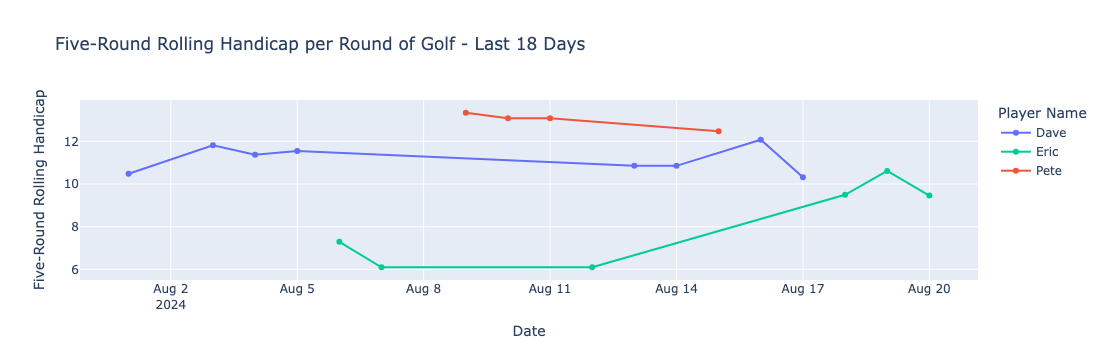

In [365]:
plot_statistics(df.head(30), "fiveRd_handicap")

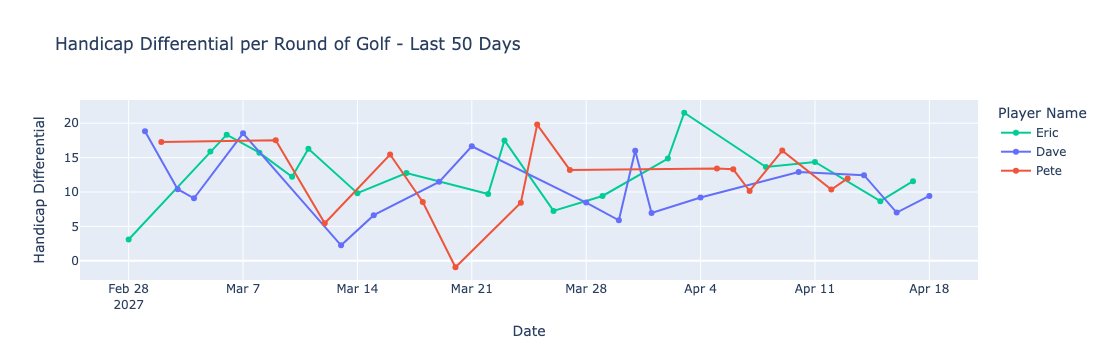

In [366]:
plot_statistics(df, "handicap_diff")

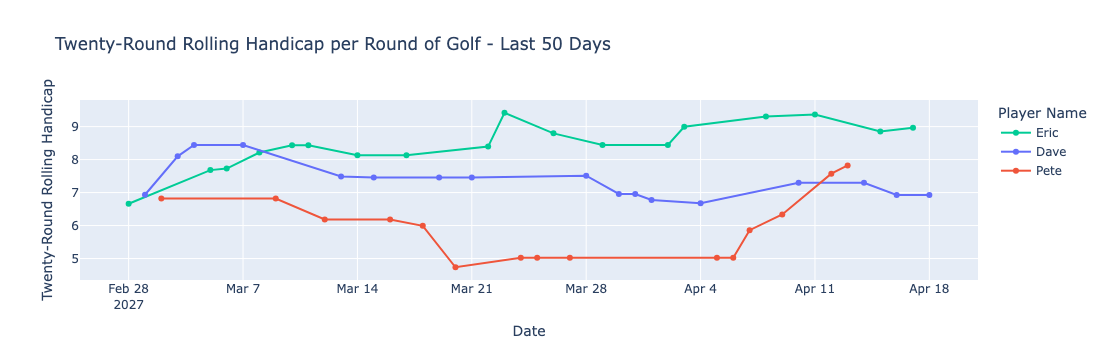

In [367]:
plot_statistics(df, "twentyRd_handicap")

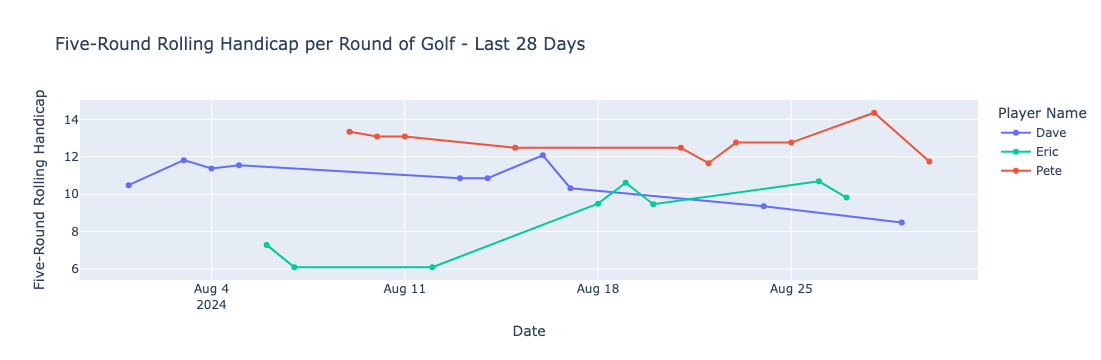

In [368]:
plot_statistics(df.head(40), "fiveRd_handicap")

In [369]:
def dist_plot(data:pd.DataFrame, column:str, color_map:dict = {"Dave":'#636EFA', "Pete":'#EF553B', "Eric":'#00CC96'}):
    """
    Function to generate a plotly figure of KDE distributions for selected columns 

    Args
    -----------
    data: pd.DataFrame | data with columns: "name" and continuous variable of interest

    Returns
    -----------
    plotly figure | kde plots overlaid 

    Errors
    -----------
    KeyError if data do not contain the correct columns
    """

    # Create the overlaid plot
    fig = go.Figure()
    
    for player in data["name"].unique():
        player_data = data.loc[data["name"]== player][column]

        player_kde = ff.create_distplot([player_data], group_labels=[player], show_hist=False, show_rug=False)
    
        # Player KDE Plot
        fig.add_trace(go.Scatter(x=player_kde['data'][0]['x'], y=player_kde['data'][0]['y'], 
                                 mode='lines', name=player, fill='tozeroy', line=dict(color=color_map[player]), opacity=0.9,
                                 hoverinfo='x', xhoverformat=".2f", hovertemplate=f'{column.replace("_", " ").title()}: %{{x:.2f}}'))
    
    # Update layout
    fig.update_layout(height=600, width=800, 
                      title_text=f"{column.replace('_', ' ').title()} Distribution",
                      xaxis_title=f"{column.replace('_', ' ').title()}",
                      yaxis_title="Density",
                      showlegend=True,
                      legend=dict(x=1, y=1, title="Player Name"))
    fig.update_yaxes(showticklabels=False)

    return fig

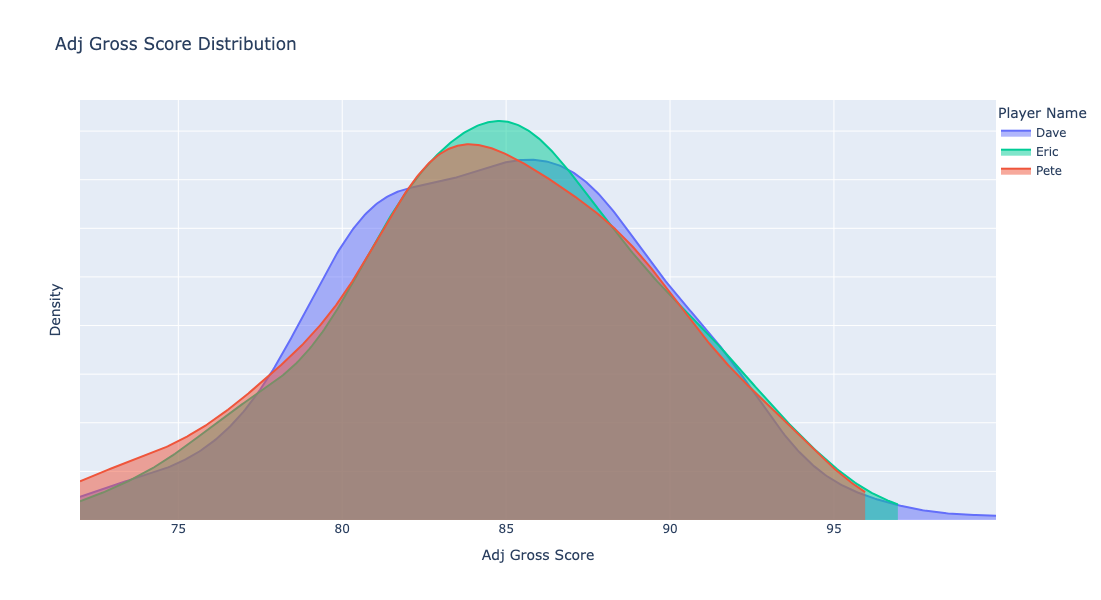

In [370]:
dist_plot(df, "adj_gross_score")

In [439]:
def histplot(data:pd.DataFrame, column:str, color_map:dict = {"Dave":'#636EFA', "Pete":'#EF553B', "Eric":'#00CC96'}):
    """ Display the distribution of a continuous numeric variable

    Args:
    ----------------
    data:pd.DataFrame | source of data
    column:str | name of the continuous variable to be plotted
    color_map:dict | dictionary of values to ensure color-coding-consistency across plots

    Returns:
    -----------------
    fig:px.Figure | a histogram of the selected continuous variable
    """

    label_dict = {
        "adj_gross_score":"Adjusted Gross Score", 
        "handicap_diff": "Handicap Differential",
        "putts": "Putts per Round",
        "3_putts": "3-Putts per Round",
        "fairways_hit": "Fairways Hit per Round",
        "gir": "Greens in Regulation",
        "penalty/ob": "Penalties / OB per Round",
        "fiveRd_handicap": "Five-Round Rolling Handicap",
        "tenRd_handicap": "Ten-Round Rolling Handicap",
        "twentyRd_handicap": "Twenty-Round Rolling Handicap"
    }
    
    fig_h = px.histogram(data, x=column, nbins=len(data[column].unique()), \
                         labels={column:label_dict[column], "count":"Count"}, hover_name="name", color="name", hover_data={"name":True},
                        color_discrete_map=color_map)
    
    
    fig_h.update_layout(yaxis={"title":"Count"}, title=f'Distribution for {label_dict[column]}', barmode="overlay",
                       legend={"title":"Player Name"})
    fig_h.update_traces(marker_line_color='black', marker_line_width=1.5, opacity=.3,
                       hovertemplate=f"<b>%{{fullData.name}}</b><br><br>{label_dict[column]}: %{{x}}<br> No. of Rounds: %{{y}}")
    return fig_h

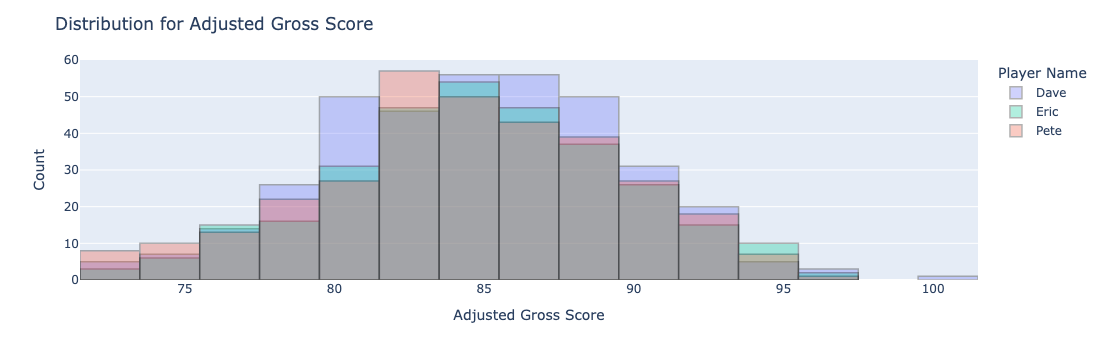

In [440]:
histplot(df, "adj_gross_score")

In [373]:
def pie_chart(data:pd.DataFrame, column:str, player:str=None):
    """
    Pie chart that shows the proportions of fairways hit, gir, 3 putts, penalties - the sub-categories of score

    Args:
    -----------------
    data:pd.DataFrame | source data containing the records of golf rounds
    column:str | name of the metric for which the proportions will be shown
    player:str | name of the player in question

    Returns:
    ------------------
    fig:px.Figure() | a pie chart with a hole in the middle displaying the proportions of values
    """

    label_dict = {
        "adj_gross_score":"Adjusted Gross Score", 
        "handicap_diff": "Handicap Differential",
        "putts": "Putts per Round",
        "3_putts": "3-Putts per Round",
        "fairways_hit": "Fairways Hit per Round",
        "gir": "Greens in Regulation",
        "penalty/ob": "Penalties / OB per Round",
        "fiveRd_handicap": "Five-Round Rolling Handicap",
        "tenRd_handicap": "Ten-Round Rolling Handicap",
        "twentyRd_handicap": "Twenty-Round Rolling Handicap"
    }
    
    if player:
        data = data.loc[data["name"] == player]

    fig = px.pie(data_frame=data, names=column, hole=.5, labels={column:label_dict[column]},
                title=f"Proportion of {label_dict[column]}", category_orders={column:[*range(data[column].max().astype(int))]})
    fig.update_layout(legend={"title":player if player else label_dict[column]})
    
    return fig

In [374]:
[*range(19)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

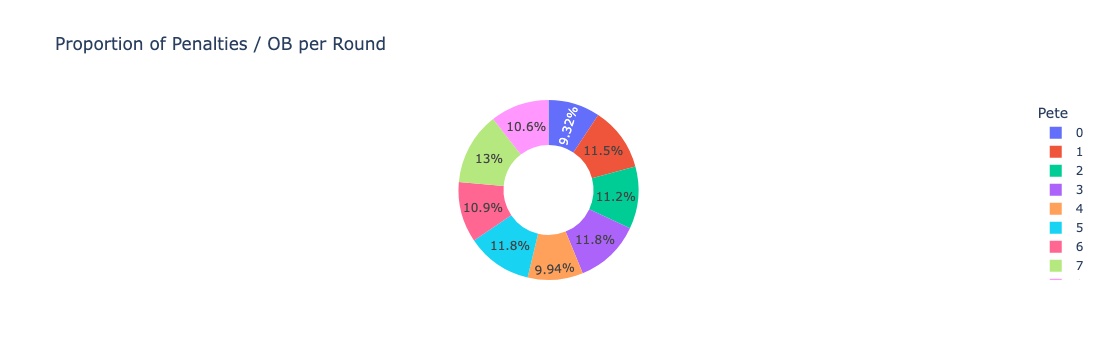

In [376]:
pie_chart(df, "penalty/ob", "Pete")

In [314]:
df.columns

Index(['name', 'date', 'adj_gross_score', 'course_rating', 'handicap_diff',
       'slope_rating', 'putts', '3_putts', 'fairways_hit', 'gir', 'penalty/ob',
       'fiveRd_handicap', 'tenRd_handicap', 'twentyRd_handicap'],
      dtype='object')

In [453]:
def mean_med_stats(data:pd.DataFrame, column:str, color_map:dict={"Dave":'#636EFA', "Pete":'#EF553B', "Eric":'#00CC96'}):
    """
    Function to generate a plotly barplots of mean and median column values

    Args:
    -----------
    data: pd.DataFrame | source of data
    column:str | value of interest to find Mean and Median values
    color_map:dict | dictionary to ensure color-coding-consistency

    Returns
    -----------
    plotly figure | barplot with Mean/Median/Stddev Values 

    Errors
    -----------
    KeyError if data do not contain the correct columns
    """

    label_dict = {
        "adj_gross_score":"Adjusted Gross Score", 
        "handicap_diff": "Handicap Differential",
        "putts": "Putts per Round",
        "3_putts": "3-Putts per Round",
        "fairways_hit": "Fairways Hit per Round",
        "gir": "Greens in Regulation",
        "penalty/ob": "Penalties / OB per Round",
        "fiveRd_handicap": "Five-Round Rolling Handicap",
        "tenRd_handicap": "Ten-Round Rolling Handicap",
        "twentyRd_handicap": "Twenty-Round Rolling Handicap"
    }
    
    # Grouping data by state and calculating median and mean
    grouped = data.groupby("name")[column].agg(["median", "mean","std"]).sort_values(by="median", ascending=False)

    # Resetting index to make 'state' a column for Plotly
    grouped = grouped.reset_index().rename(columns={"median":"Median", "mean":"Average", "std":"Standard Deviation"})

    # Creating Plotly figure
    fig = px.bar(grouped, x='name', y=['Median', 'Average', "Standard Deviation"],
                 labels={'value': label_dict[column], 'name': 'Player Name', "variable":"Statistic"},
                 title=f'Mean and Median {label_dict[column]}<br><sup>Aggregate Statistics for Each Player</sup>', hover_name="name",
                 hover_data={"name":False},
                 template="seaborn", 
                barmode='group')
    
    # Legend/layout
    fig.update_layout(legend_title='Statistics', title={"x":0, "y":.85,})

    fig.for_each_trace(lambda t: t.update(name=t.name.capitalize()))
    fig.update_layout(yaxis=dict(tickformat='.2f'))
    # Returning the Plotly figure
    return fig

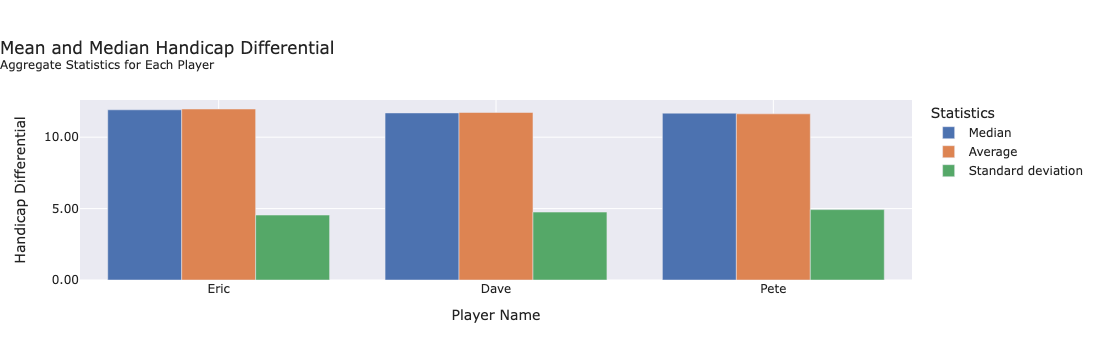

In [454]:
mean_med_stats(df, "handicap_diff")

In [481]:
def rolling_avg(data:pd.DataFrame, column:str, window:int, color_map:dict={"Dave":'#636EFA', "Pete":'#EF553B', "Eric":'#00CC96'}):
    """
    Function to generate a plotly lineplots of rolling mean column values

    Args:
    -----------
    data: pd.DataFrame | source of data
    column:str | value of interest to find Mean and Median values
    window:int | number of periods for which to find a rolling average
    color_map:dict | dictionary to ensure color-coding-consistency

    Returns
    -----------
    plotly figure | lineplot with hover values of State, Mean/Median Value 

    Errors
    -----------
    KeyError if data do not contain the correct columns
    """

    label_dict = {
        "adj_gross_score":"Adjusted Gross Score", 
        "handicap_diff": "Handicap Differential",
        "putts": "Putts per Round",
        "3_putts": "3-Putts per Round",
        "fairways_hit": "Fairways Hit per Round",
        "gir": "Greens in Regulation",
        "penalty/ob": "Penalties / OB per Round",
        "fiveRd_handicap": "Five-Round Rolling Handicap",
        "tenRd_handicap": "Ten-Round Rolling Handicap",
        "twentyRd_handicap": "Twenty-Round Rolling Handicap"
    }

    data = data.set_index("date").sort_index()
    data["rolling_avg"] = data.groupby("name")[column].transform(lambda t: t.rolling(window).mean())
    
    fig = px.line(data_frame = data, y="rolling_avg", color="name", color_discrete_map=color_map, 
                 title=f"{window} Round Rolling Average - {label_dict[column]}", hover_name="name",
                 labels={"rolling_avg":"Rolling Avg", "date":"Date Played"}, hover_data={"name":False})
    fig.update_layout(legend={"title":"Player Name"})
    return fig

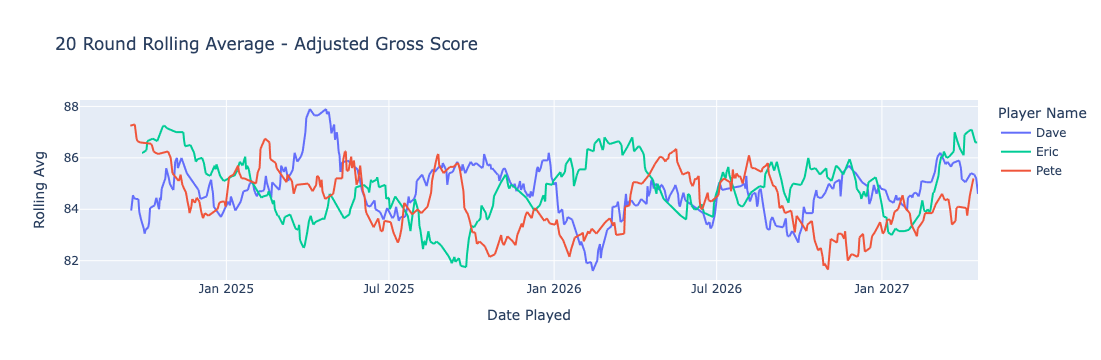

In [482]:
rolling_avg(df, "adj_gross_score", 20)

In [533]:
def scatter(data:pd.DataFrame, column:str, color_map:dict={"Dave":'#636EFA', "Pete":'#EF553B', "Eric":'#00CC96'}, size:str=None,
           jitter_strength=0.25):
    """
    Scatterplot of adjusted gross score on the y-axis vs a selected contributing column on the x-axis

    Args:
    -------------
    data:pd.DataFrame | source of data
    column:str | selected contributing column, i.e. 3-putts, putts, fairways, gir, etc
    color_map:dict | color mapping to ensure color-consistency
    size:str | optional additional contributing column to include more dimensions
    jitter_strenght:float | amount of jitter for the x-axis values

    Returns:
    --------------
    fig:plotly.graph_objects.Figure | scatterplot with color-coded player relationships, options for how to plot additional dimensions
    
    """
    label_dict = {
        "adj_gross_score":"Adjusted Gross Score", 
        "handicap_diff": "Handicap Differential",
        "putts": "Putts per Round",
        "3_putts": "3-Putts per Round",
        "fairways_hit": "Fairways Hit per Round",
        "gir": "Greens in Regulation",
        "penalty/ob": "Penalties / OB per Round",
        "fiveRd_handicap": "Five-Round Rolling Handicap",
        "tenRd_handicap": "Ten-Round Rolling Handicap",
        "twentyRd_handicap": "Twenty-Round Rolling Handicap"
    }

    if size:
        title = f"Adj Score vs {label_dict[column]} with {label_dict[size]} as Size<br><sup>X-Jittered for Visibility</sup>"
    else:
        title = f"Adj Score vs {label_dict[column]}<br><sup>X-Jittered for Visibility</sup>"

    data["jittered_col"] = data[column] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df))
    
    fig = px.scatter(data_frame=data, x="jittered_col", y="adj_gross_score", color="name", size=size,
                     hover_name="name", labels={"adj_gross_score":"Adj. Score", "jittered_col":label_dict[column]}, 
                     title = title, hover_data={"name":False, "jittered_col":":.0f"})

    fig.update_layout(legend={"title":"Player Name"}, title={"y":.85})
    fig.update_traces(opacity=.6)
    
    return fig

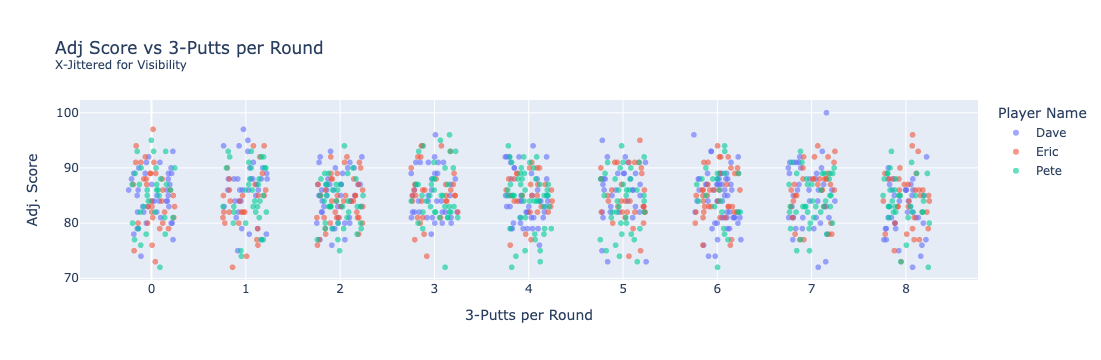

In [535]:
scatter(df,"3_putts")

In [536]:
df.head(30)

,name,date,adj_gross_score,course_rating,handicap_diff,slope_rating,putts,3_putts,fairways_hit,gir,penalty/ob,fiveRd_handicap,tenRd_handicap,twentyRd_handicap,jittered_col
0,Dave,2024-07-22,80,72.0,8.000000,113.0,36,0,6,12,1,NaN,NaN,NaN,-0.055357
1,Dave,2024-07-23,90,71.0,19.169643,112.0,48,0,8,15,7,NaN,NaN,NaN,0.206947
2,Eric,2024-07-24,88,72.0,16.436364,110.0,41,7,7,9,1,NaN,NaN,NaN,7.160304
3,Dave,2024-07-25,86,73.0,11.476562,128.0,44,5,0,7,0,NaN,NaN,NaN,4.799161
4,Pete,2024-07-26,86,72.0,12.861789,123.0,43,8,12,1,0,NaN,NaN,NaN,7.831199
5,Dave,2024-07-27,86,73.5,11.970339,118.0,41,2,12,3,1,NaN,NaN,NaN,1.803593
6,Eric,2024-07-28,85,71.5,11.917969,128.0,47,8,8,13,0,NaN,NaN,NaN,8.240733
7,Pete,2024-07-29,93,73.5,19.674107,112.0,18,3,12,1,8,NaN,NaN,NaN,2.833077
8,Pete,2024-07-30,90,72.0,16.403226,124.0,48,5,5,15,3,NaN,NaN,NaN,5.082658
9,Eric,2024-07-31,73,71.0,1.822581,124.0,47,8,8,2,6,NaN,NaN,NaN,7.948697
